# Assignement 5: Support Vector Machines

5번째 과제에서는 **Support Vector Machines algorithm**과 python의 **CVXOPT API**를 사용하여 Decision boundary와 Support vectore을 구해봅시다. 
수학적 형태의 알고리즘은 다소 이해하기 쉽지만, **CVXOPT API**를 사용한 매트릭스 형태의 알고리즘 구현은 처음에는 어려울 수 있습니다.   
이번 과제에서 API에 필요한 입력뿐만 아니라, 데이터들을 적절하게 벡터화하는 표기법을 도출하는 데 필요한 단계를 구현할 것입니다.   
Dataset은 이전 Logistic regression에서 사용한 ex2data1.txt를 사용합니다.  
*Dataset from Andrew Ng's coursera lecture*

In [411]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

## Quesion1: SVM를 구현하기위한 데이터를 읽어옵시다.

In [412]:
# Put your code
train_data = np.loadtxt('ex2data1.txt',delimiter=',')

## 이전 과제해서 구현했듯이, 학생들의 점수 분포를 나타내볼까요?  

Exam 1, Exam 2를 각각 x,y 축으로 놓고, Admission의 결과에 따라 1인 경우 파란 삼각형, 0인 경우 노란 사각형으로 표시하세요.

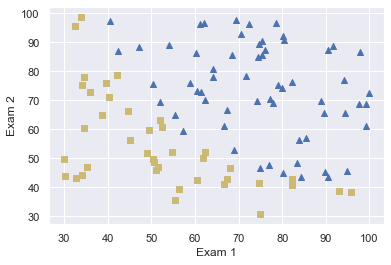

In [413]:
def plot_data():
    plt.xlabel('Exam 1')
    plt.ylabel('Exam 2')
    for i in range(len(train_data)):
        x=train_data[i][0]
        y=train_data[i][1]

        if train_data[i][2]==1:
           plt.scatter(x,y,marker='^',c='b')
        elif train_data[i][2]==0:
           plt.scatter(x,y,marker='s',c='y')
            

plot_data()


## Quesion2: Data arrangement  

읽어온 Data를 요구사항에 맞게 정리해봅시다. 

#### 1. Ndarray 'X'를 정의한다. 
* X는 먼저 dataset에서 admission이 1인 학생의 점수를 우선적으로 배치하고 그 다음으로 admission이 0인 학생들의 점수를 배치한다.  
쉽게말해서 합격인 학생들의 점수와 불합격인 학생들의 점수를 stack하면 된다.

| Exam 1 | Exam 2 |
| --- | --- |
|admin_data | admin_data |
|admin_data | admin_data |
| ... | ... |
| ... | ... |
|no_admin_data | no_admin_data |
|no_admin_data | no_admin_data |

#### 2. Ndarray 'y'를 정의한다. 
* y는 각 점수들에 대한 admission을 나타내면 된다. 즉 X의 데이터와 상응하는 admission value를 가지고 있으면 된다. 여기서 변경할 점은 불합격인 학생들의 admission value를 0이 아닌 -1로 대체해준다.  

| admission |
| --- |
| 1 |
| 1 |
| 1 |
| ... |
| -1 |
| -1 |
| -1 |  

해당 구현을 진행했다면, X와 y를 출력하자.  

In [414]:
train_sort= train_data[train_data[:,2].argsort()[::-1]]
train_sort= np.where(train_sort==0,-1,train_sort)

X=train_sort[:,:2]
y=train_sort[:,2:3]
print(X,y)

[[74.775893   89.5298129 ]
 [97.77159928 86.72782233]
 [85.40451939 57.05198398]
 [52.04540477 69.43286012]
 [64.17698887 80.90806059]
 [83.90239366 56.30804622]
 [94.44336777 65.56892161]
 [77.19303493 70.4582    ]
 [62.0730638  96.76882412]
 [75.39561147 85.75993667]
 [55.34001756 64.93193801]
 [79.94481794 74.16311935]
 [99.27252693 60.999031  ]
 [90.54671411 43.39060181]
 [97.64563396 68.86157272]
 [74.24869137 69.82457123]
 [61.37928945 72.80788731]
 [80.19018075 44.82162893]
 [62.27101367 69.95445795]
 [77.92409145 68.97235999]
 [89.67677575 65.79936593]
 [76.97878373 47.57596365]
 [70.66150955 92.92713789]
 [69.07014406 52.74046973]
 [53.97105215 89.20735014]
 [69.36458876 97.71869196]
 [82.30705337 76.4819633 ]
 [84.43281996 43.53339331]
 [76.0987867  87.42056972]
 [75.02474557 46.55401354]
 [61.10666454 96.51142588]
 [79.03273605 75.34437644]
 [60.18259939 86.3085521 ]
 [71.79646206 78.45356225]
 [91.5649745  88.69629255]
 [67.31925747 66.58935318]
 [75.47770201 90.424539  ]
 

## Support Vector Machines algorithm

수업시간에 배운 수학적으로 유도한 것을 다소 이해하기 쉽지만, Python의 **CVXOPT**을 사용해서 구현하는 것엔 익숙하지 않으실 수 있습니다.  
  
  
수업시간에 배운대로 SVM Problem을 해결하기 위해선 다음 단계를 따릅니다. 
* Create P where $$H_{i,j} = y^iy^j<x^ix^j>$$  
* Calculate  $$ w = \sum_{i=1}^{m} y^i\alpha_ix^i$$
* Determine the set of support vectors S by finding the indices such that $$\alpha_i > 0$$
* Calculate the intercept term using $$ b = y^s - \sum_{m\in S}\alpha_m y^m<x^mx^s>$$

최종적으로 Decision boundary를 구할 수 있고, Support vectors을 구할 수 있습니다.  

우리는 cvxopt모듈에 있는 cvxopt_solvers.qp()라는 함수를 사용할 예정입니다.  
Ref: https://cvxopt.org/userguide/coneprog.html)

참조 문서에도 나와있듯이 다음과 같은 수식을 사용합니다.  
$$Minimize {1\over2}x^TPx+q^Tx$$
$$s.t.  Gx <= h$$
$$Ax = b$$

그리고 이 것을 함수 parameter를 다음과 같이 이용합니다. 
$$cvxopt.solvers.qp(P, q[, G, h[, A, b[, solver[, initvals]]]])$$  

Dual problem을 상기해보면 다음과 같다. 
$${Max\over \alpha} \sum_{i}^{m} \alpha_i - {1 \over 2}\sum_{i,j}^{m}y^iy^j\alpha_i\alpha_j<x^ix^j>$$  

위에서 언급한 matrix H를 치환해보자.  
$$ {Max\over \alpha} \sum_{i}^{m}\alpha - {1\over 2)}\alpha^TH\alpha$$
$$ s.t. -\alpha_i <= 0$$
$$ s.t. y^T\alpha=0$$  

## Quesion3: Transform Ndarray into cvxopt format  

해결하려는 문제가 vectorized form으로 변했습니다.  
우리는 다음으로 numpy array(Ndarray)를 cvxopt format으로 변환해줘야 합니다.  
  
  
앞서 언급한 cvxopt_solvers.qp에 들어가는 parameter를 SVM에 맞게 변환해주시면 됩니다.  
cvxopt 모듈의 cvxopt_matrix()를 사용하고, 인자로는 Ndarray를 넣어주시면 변환이 됩니다. 
해당 질문은 cvxopt_solvers.qp에 들어갈 인자를 구하는 section입니다.  

In [415]:
# Put your code 
# Calulate H
m,n = X.shape
y_X= y*X
H = np.dot(y_X,y_X.T)*1
# Transform data into cvxopt format
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m,1)))
G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) *10)))
A = cvxopt_matrix(y.reshape(1,-1))
b =cvxopt_matrix(np.zeros(1))

# Setting solver parameter (decrease tolerance option)
cvxopt_solvers.options['show_progress'] = False
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

## Quesion4: Run solver then, find w and b, 이전 질문에서 변환한 matrix들을 solver에 넣어서 실행해봅니다.alpha값들을 통해서 w와 b를 구해봅시다. 

In [416]:
# Put your code 
sol = cvxopt_solvers.qp(P,q,G,h,A,b)
alphas = np.array(sol['x'])

# Selecting the set of indices S corresponding to non zero values.
S = (alphas > 1e-4).flatten()

# calculate w and b 
w = ((y*alphas).T @X).reshape(-1,1)
b = y[S]-np.dot(X[S],w)

# Print result
print("Alphas= ", alphas[alphas > 1e-4])
print("w = ", w.flatten())
print("b = ", b[0])

Alphas=  [10.         10.         10.         10.         10.          5.97210466
 10.         10.         10.         10.         10.         10.
  8.29893807  7.6731666  10.         10.         10.         10.
 10.         10.         10.         10.        ]
w =  [0.14878154 0.14396855]
b =  [-16.7395432]


### 값을 제대로 구한 것인지 확인하고 싶으시면  sklearn.svm import SVC 를 사용하시면 바로 구하실 수 있습니다. 

In [417]:
clf = SVC(C = 10, kernel = 'linear')
clf.fit(X, y.ravel()) 

print('w = ',clf.coef_)
print('b = ',clf.intercept_)
print('Indices of support vectors: \n', clf.support_)
print('Support vectors: \n', clf.support_vectors_)

w =  [[0.14847028 0.1439516 ]]
b =  [-17.80897125]
Indices of support vectors: 
 [63 65 67 73 74 75 81 87 91 93 96  3 10 17 21 23 27 29 39 44 51 56]
Support vectors: 
 [[42.07545454 78.844786  ]
 [67.94685548 46.67857411]
 [39.53833914 76.03681085]
 [95.86155507 38.22527806]
 [52.10797973 63.12762377]
 [93.1143888  38.80067034]
 [32.57720017 95.59854761]
 [82.36875376 40.61825516]
 [74.78925296 41.57341523]
 [33.91550011 98.86943574]
 [82.22666158 42.71987854]
 [52.04540477 69.43286012]
 [55.34001756 64.93193801]
 [80.19018075 44.82162893]
 [76.97878373 47.57596365]
 [69.07014406 52.74046973]
 [84.43281996 43.53339331]
 [75.02474557 46.55401354]
 [50.4581598  75.80985953]
 [57.23870632 59.51428198]
 [66.74671857 60.99139403]
 [42.26170081 87.10385094]]


## Quesion5: 앞서 구한 w와 b로 Decision boundary와 추가적으로 Support vectors도 plot합니다. 
  
  
#### 여기서 Support vector는 sklearn.svm 모듈을 통해 구한 것이 아닌 cvxopt solver로 구한 값으로 구하셔야 합니다. 
**Decision boundary** $$ w^Tx +b = 0 $$

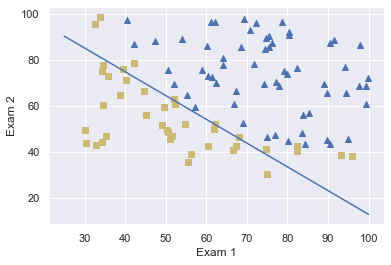

In [418]:
# Put your code
# Plot All data and Decision boundary

# a: 기울기, xx: x1, yy: x2
def Decision_boundary(x1,x2):
  plot_data()
  a= -w[0]/w[1]
  xx = np.linspace(25,100)
  yy = -a*xx+b[0]/w[1]
  plt.plot(xx,yy)

decision_boundary(xx,yy)  


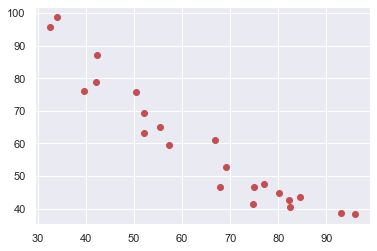

In [419]:
# Put your code
# Plot Only support vector
svm=[]
for i in range(len(X)):
    if S[i] :
        svm.append([X[i][0],X[i][1],y[i][0]])

def svm_plot():

    for i in range(len(svm)):
        if svm[i][2] <= 1:
            plt.scatter(svm[i][0], svm[i][1],c='r')
plt.show()
svm_plot()    

